In [1]:
import sys
sys.path.append("..")

from src.datasets import ChesapeakeRSC
from src.modules import CustomSemanticSegmentationTask
import torch
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_latest_checkpoint_from_dir(dir):
    largest_epoch = 0
    largest_epoch_fn = None
    for fn in os.listdir(dir):
        if fn.endswith(".ckpt") and fn != "last.ckpt":
            base = os.path.basename(fn)[:-5]
            parts = base.split("-")
            epoch = int(parts[0].split("=")[1])
            if epoch > largest_epoch:
                largest_epoch = epoch
                largest_epoch_fn = fn
    return os.path.join(dir, largest_epoch_fn), largest_epoch

In [3]:
experiment_dirs = [
    "../logs/default_unet_resnet18/lightning_logs/version_0/checkpoints/",
    "../logs/default_unet_resnet50/lightning_logs/version_0/checkpoints/",
    "../logs/default_deeplabv3+_resnet18/lightning_logs/version_0/checkpoints/",
    "../logs/default_deeplabv3+_resnet50/lightning_logs/version_0/checkpoints/"
]

In [4]:
device = torch.device("cuda:3")

In [11]:
def preprocess(sample):
    sample["image"] = sample["image"].float() / 255
    return sample

ds = ChesapeakeRSC("../data/ChesapeakeRSCSpatialReasoning/", split="test", differentiate_tree_canopy_over_roads=True, transforms=preprocess)

In [12]:
model_fn, epoch = get_latest_checkpoint_from_dir(experiment_dirs[0])
task = CustomSemanticSegmentationTask.load_from_checkpoint(model_fn, map_location="cpu")
model = task.model.eval().to(device)

In [13]:
def predict_on_one(sample, model, device):
    with torch.inference_mode():
        image = sample["image"].unsqueeze(0).to(device)
        output = model(image)
        output = torch.argmax(output, dim=1).squeeze(0).cpu()
    sample["prediction"] = output
    return sample

In [14]:
def custom_plot(sample, show_mask=True):
    img = sample["image"].numpy().transpose(1, 2, 0)[:, :, :3]
    mask = sample["mask"].numpy()
    prediction = sample["prediction"].numpy()

    img_masked_labels = img.copy()
    img_masked_predictions = img.copy()

    img_masked_labels[mask == 1] += np.array([0.0, 0.0, 0.5])
    img_masked_labels[mask == 2] += np.array([0.5, 0.0, 0.0])
    img_masked_labels[img_masked_labels > 1] = 1

    img_masked_predictions[prediction == 1] += np.array([0.0, 0.0, 0.5])
    img_masked_predictions[img_masked_predictions > 1] = 1

    n_cols = 1
    width = 5
    if show_mask:
        n_cols = 2
        width = 10

    fig, axs = plt.subplots(1, n_cols, figsize=(width, 5))
    if not show_mask:
        axs = [axs]

    if show_mask:
        axs[0].imshow(img_masked_labels)
        axs[1].imshow(img_masked_predictions)
    else:
        axs[0].imshow(img_masked_predictions)
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()

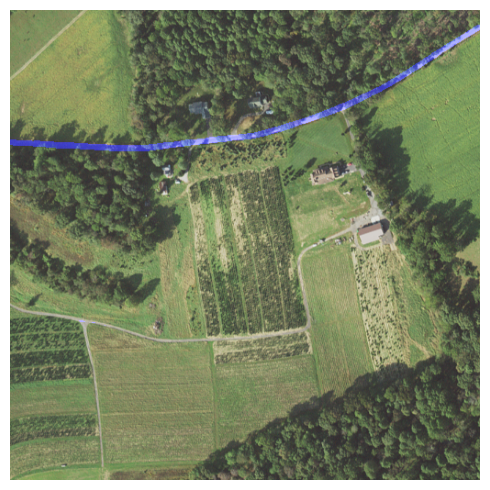

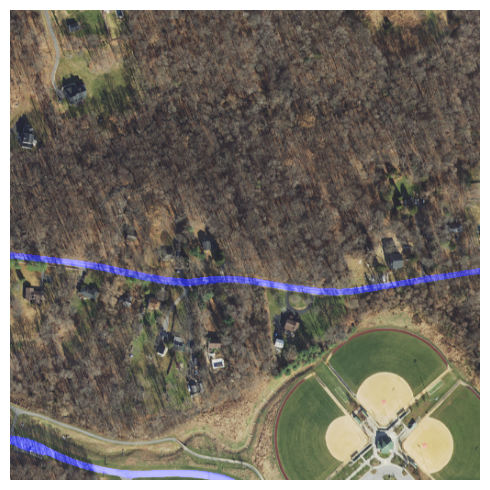

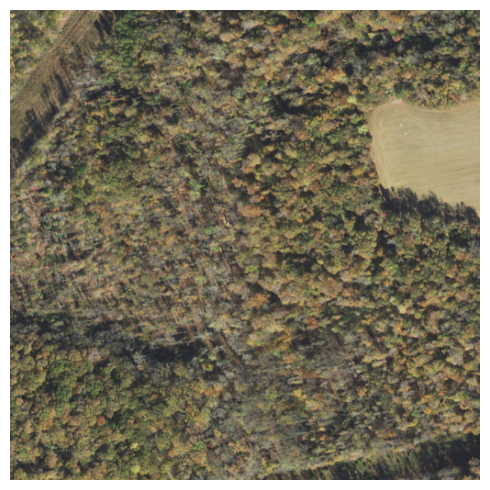

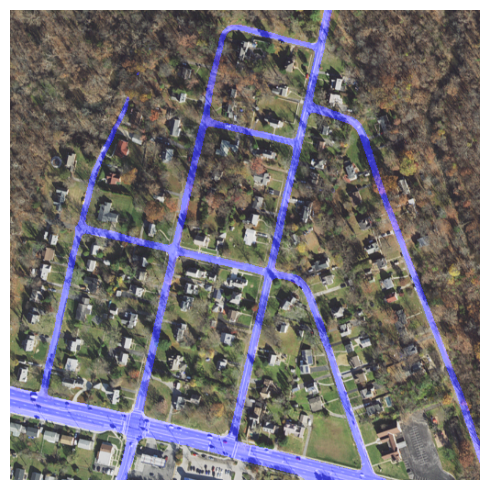

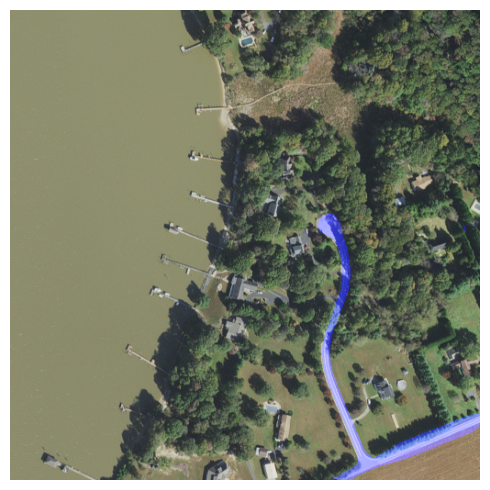

In [15]:
for i in np.random.choice(len(ds), 5):
    sample = predict_on_one(ds[i], model, device)
    custom_plot(sample, False)